# Custom Football ELO Rating

To implement the ELO system, I adapted the code from https://www.kaggle.com/code/thomasstokes/custom-football-elo-rating/execution .

# Implementation

Now we have gone over the mathematics behind the ELO rating system, we will finally start coding.

In [1]:
# Imports

import os
import numpy as np
import math
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
# Import Data
df = pd.read_csv('../data/results_.csv',parse_dates= ["date"]) ## match results from 1872 to 2022 We need data starting from 1929

In [3]:
df =df[df['date']>pd.Timestamp('1929-01-01 00:00:00')]

In [4]:
df.sort_values(by="date", ascending=False)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
44340,2022-12-06,Portugal,Switzerland,6,1,FIFA World Cup,Lusail,Qatar,True
44339,2022-12-06,Morocco,Spain,0,0,FIFA World Cup,Al Rayyan,Qatar,True
44338,2022-12-05,Brazil,South Korea,4,1,FIFA World Cup,Doha,Qatar,True
44337,2022-12-05,Japan,Croatia,1,1,FIFA World Cup,Al Wakrah,Qatar,True
44336,2022-12-04,England,Senegal,3,0,FIFA World Cup,Al Khor,Qatar,True
...,...,...,...,...,...,...,...,...,...
1185,1929-03-03,Italy,Czechoslovakia,4,2,Central European International Cup,Bologna,Italy,False
1184,1929-02-24,France,Hungary,3,0,Friendly,Colombes,France,False
1183,1929-02-23,Northern Ireland,Scotland,3,7,British Home Championship,Belfast,Northern Ireland,False
1182,1929-02-10,Germany,Switzerland,7,1,Friendly,Mannheim,Germany,False


In [5]:
fix = df[['date', 'home_team', 'away_team', 'home_score', 'away_score','tournament']].copy()
fix = fix.reset_index()
fix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43160 entries, 0 to 43159
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   index       43160 non-null  int64         
 1   date        43160 non-null  datetime64[ns]
 2   home_team   43160 non-null  object        
 3   away_team   43160 non-null  object        
 4   home_score  43160 non-null  int64         
 5   away_score  43160 non-null  int64         
 6   tournament  43160 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 2.3+ MB


In [6]:
world_cup = ['FIFA World Cup']
continental_tournaments = ['WAFF Championship','EAFF Championship','AFF Championship','CONCACAF Nations League','Intercontinental Cup','UEFA Nations League','Nations Cup','African Nations Championship','African Nations Championship','Copa América','AFC Asian Cup',
 'African Cup of Nations','UEFA Euro','CONCACAF Championship','Confederations Cup']
continental_qualifiers = ['CONCACAF Nations League qualification',
 'African Nations Championship qualification','AFF Championship qualification','Copa América qualification','CONCACAF Championship qualification','FIFA World Cup qualification','AFC Asian Cup qualification','UEFA Euro qualification','African Cup of Nations qualification']
other_tournaments = ['VFF Cup',
 'Dragon Cup',
 'ABCS Tournament',
 'Nile Basin Tournament',
 'Copa Confraternidad',
 'Pacific Games',
 'Superclásico de las Américas',
 'Kirin Challenge Cup',
 'OSN Cup',
 'CONIFA World Football Cup',
 'CONIFA European Football Cup',
 'World Unity Cup',
 'Pacific Mini Games',
 'Atlantic Heritage Cup',
 'Inter Games Football Tournament',
 'Three Nations Cup',
 'Mahinda Rajapaksa Cup',
 'Navruz Cup',
 'CONIFA Africa Football Cup',
 'CONIFA South America Football Cup',
 "MSG Prime Minister's Cup",'United Arab Emirates Friendship Tournament',
 'Oceania Nations Cup qualification',
 'Simba Tournament',
 'SAFF Cup',
 'King Hassan II Tournament',
 'Cyprus International Tournament',
 'Dunhill Cup',
 'COSAFA Cup qualification',
 'COSAFA Cup',
 'Gold Cup qualification',
 'SKN Football Festival',
 'UNIFFAC Cup',
 'Millennium Cup',
 'Cup of Ancient Civilizations',
 "Prime Minister's Cup",
 'TIFOCO Tournament',
 'Afro-Asian Games',
 'AFC Challenge Cup',
 'FIFI Wild Cup',
 'ELF Cup',
 'Viva World Cup',
 'AFC Challenge Cup qualification','British Home Championship','Central European International Cup','Nordic Championship','Baltic Cup',
 'Copa Newton',
 'Copa Lipton',
 'Balkan Cup','Copa Chevallier Boutell',
 'Copa Rio Branco','Bolivarian Games',
 'Copa Roca',
 'CCCF Championship',
 'NAFU Championship',
 'Copa Oswaldo Cruz',
 'Pan American Championship',
 'Copa del Pacífico',
 "Copa Bernardo O'Higgins",'Atlantic Cup','Copa Paz del Chaco',
 'Merdeka Tournament','Windward Islands Tournament','Vietnam Independence Cup',
 'Copa Carlos Dittborn',
 'Phillip Seaga Cup','Copa Juan Pinto Durán',
 'Arab Cup',
 'South Pacific Games','Copa Artigas',
 'GaNEFo',
 "King's Cup",
 'Gulf Cup',
 'Indonesia Tournament',
 'Korea Cup',
 'Palestine Cup',
 'Brazil Independence Cup',
 'Copa Ramón Castilla',
 'Oceania Nations Cup',
 'CECAFA Cup',
 'Kuneitra Cup',
 'Copa Félix Bogado',
 'Real Madrid 75th Anniversary Cup',
 'Beijing International Friendship Tournament',
 'Kirin Cup',
 'CFU Caribbean Cup qualification',
 'CFU Caribbean Cup',
 'Amílcar Cabral Cup',
 'FIFA 75th Anniversary Cup',
 'Guangzhou International Friendship Tournament',
 'Mundialito',
 'West African Cup',
 'Nehru Cup',
 'Merlion Cup',
 'Great Wall Cup',
 'UDEAC Cup',
 'Rous Cup',
 'CONMEBOL–UEFA Cup of Champions',
 'Lunar New Year Cup',
 'Arab Cup qualification',
 'Tournoi de France',
 'Malta International Tournament',
 'Matthews Cup',
 'Tournament Burkina Faso',
 'Island Games',
 'Dynasty Cup',
 'Dakar Tournament',
 'UNCAF Cup',
 'Gold Cup',
 'USA Cup',
 'Jordan International Tournament']
friendly = ['Friendly']

## Functions

In [7]:
def compute_weight(tournament,x,y):
    cte = 0
    if tournament in world_cup:
        cte = 60
    elif tournament in continental_tournaments:
        cte =50
    elif tournament in continental_qualifiers:
        cte = 40
    elif tournament in other_tournaments:
        cte = 30
    else:
        cte=20
    goal_diff = abs(x-y)
    if goal_diff ==2:
        cte+=0.5
    elif goal_diff==3:
        cte+=0.75
    elif goal_diff>3:
        cte+= 0.75 + (goal_diff-3)/8
    
    return cte
def expected_score(x,y):
    return 1/(math.pow(10,-(x-y)/400) +1)
# Expected Score
def score(old_home_score, old_away_score, r,tournament,hts,ats):
    weight = compute_weight(tournament, hts,ats)
    old_home_score += weight * (r - expected_score(old_home_score,old_away_score)) 
    old_away_score += weight* ((1 - r) - expected_score(old_away_score,old_home_score)) 
    return [old_home_score, old_away_score]

# Actual Result
def result(a, b):
    if a > b:
        return 1
    if a == b:
        return 0.5
    if a < b:
        return 0

In [8]:
fix.head()

,index,date,home_team,away_team,home_score,away_score,tournament
0,1181,1929-02-02,Wales,Northern Ireland,2,2,British Home Championship
1,1182,1929-02-10,Germany,Switzerland,7,1,Friendly
2,1183,1929-02-23,Northern Ireland,Scotland,3,7,British Home Championship
3,1184,1929-02-24,France,Hungary,3,0,Friendly
4,1185,1929-03-03,Italy,Czechoslovakia,4,2,Central European International Cup


## Calculating the ELO ratings

In [9]:
# Score Dictionaries
keys = [] # Teams
dict_score = {} # Current ELO score
dict_timeline = {} # History of ELO Scores

# Score Calculator
year_now = 1929 # Starting year
# Loops through every match
for i in range(len(df.date)):
    date = fix.date[i]
    year = date.year
    tournament_ = fix.tournament[i]
    # Checks if the year is different from the current year
    if year != year_now:
        dict_ = dict_score.copy()
        dict_timeline[year_now] = dict_
        year_now = year
    ht = fix.home_team[i]
    at = fix.away_team[i]
    hts = fix.home_score[i]
    ats = fix.away_score[i]
    r = result(hts, ats)
    # If both the home and away teams are new
    if ht not in keys and at not in keys:
        keys.append(ht)
        keys.append(at)
        dict_score[ht] = 1000
        dict_score[at] = 1000
        old_home_score= dict_score[ht]
        old_away_score = dict_score[at]
        s = score(old_home_score, old_away_score, r,tournament_,hts,ats)
        dict_score[ht] = s[0] 
        dict_score[at] = s[1] 
    # If there are no new teams
    if ht in keys and at in keys:
        old_home_score= dict_score[ht]
        old_away_score = dict_score[at]
        s = score(old_home_score, old_away_score, r,tournament_,hts,ats)
        dict_score[ht] = s[0] 
        dict_score[at] = s[1]
    # If only the home team is new
    elif ht not in keys:
        keys.append(ht)
        dict_score[ht] = 1000
        old_home_score= dict_score[ht]
        old_away_score = dict_score[at]
        s = score(old_home_score, old_away_score, r,tournament_,hts,ats)
        dict_score[ht] = s[0] 
        dict_score[at] = s[1]
    # If only the away team is new
    elif at not in keys:
        keys.append(at)
        dict_score[at] = 1000
        old_home_score= dict_score[ht]
        old_away_score = dict_score[at]
        s = score(old_home_score, old_away_score, r,tournament_,hts,ats)
        dict_score[ht] = s[0]
        dict_score[at] = s[1] 

In [10]:
# Creates a timeline of score the for each country
year = []
dict_ = {}
for country in keys:
    dict_[country] = []
for y in list(dict_timeline.keys()):
    dict = dict_timeline[y]
    year.append(y)
    for country in keys:
        if country in list(dict.keys()):
            dict_[country] += [dict[country]]
        else:
            dict_[country] += [0]

In [11]:
# Shows Each Countries score over time
df_timeline = pd.DataFrame({'country': list(dict_.keys())})
for i in range(len(year)):
    col = []
    y = year[i]
    for country in list(dict_.keys()):
        d = dict_[country]
        col.append(d[i])
    df_timeline[str(y)] = col
    df_timeline[str(y)] = round(df_timeline[str(y)])
df_timeline = df_timeline.sort_values('2019', ascending=False).reset_index(drop='index')

In [12]:
## loop over existing WCs & filter teams that reached semi finals.
## calculate the ELO rating for each team directly before the start of each world cup. 
## 
return_dict = {"Semi_Finalists":[], "Year":[], "Average_Opponent_Rating":[], "Hurdle": []}
wc_years = []; wc_years.extend(range(1930,1939,4) )
wc_years.extend(range(1950,2023,4))

for year in wc_years:
    year_match_data = fix[(fix.date >= pd.Timestamp(str(year)+'-01-01 00:00:00'))&(fix.date <= pd.Timestamp(str(year)+'-12-31 00:00:00'))].copy()
    wc_start = pd.Timestamp(year_match_data[year_match_data.tournament.isin(world_cup)].date.values[0])
    match_before_wc = year_match_data[(year_match_data.date <wc_start)].copy()

    wc_matches = year_match_data[year_match_data.tournament.isin(world_cup)].copy()
    
    wc_matches.sort_values(by="date",ascending=True, inplace=True)
    wc_matches.reset_index(inplace=True)
    index_to_drop = [len(wc_matches.date)-1]
    if year>=1954: ## World cup year with the first third place match 
        index_to_drop.append(len(wc_matches.date)-2)
    if year!=2022:
        wc_matches.drop(index=index_to_drop,axis=0,inplace=True)
    
    semi_finals = wc_matches.loc[len(wc_matches.date)-2:] ## check for third place match
    semi_finalists = semi_finals.home_team.tolist() + semi_finals.away_team.tolist()
    semi_finalists = list(set(semi_finalists))
    if year!=2022:
        wc_matches.drop(index=[len(wc_matches.date)-2,len(wc_matches.date)-1],axis=0,inplace=True)
    
    wc_teams = wc_matches.home_team.tolist() + wc_matches.away_team.tolist()
    wc_teams = list(set(wc_teams))
    
    if year==2022: ##semi Finals are missing
        semi_finalists = ['Morocco', 'France', 'Argentina', 'Croatia']
    
    ### Compute initial ELO of the year.  
    initial_elo = df_timeline[['country', str(year-1)]].copy()
    initial_elo = initial_elo[initial_elo['country'].isin(wc_teams)]
    initial_elo[str(year-1)][initial_elo[str(year-1)]== 0]= 1000
    
    ### Compute Run Scores 
    ### Run Score will be the sum ELO ratings of faced opponents 
    for semi_finalist in semi_finalists:
        sf_matches = wc_matches[(wc_matches['home_team']==semi_finalist)|(wc_matches['away_team']==semi_finalist)]
        opponents = list(set(sf_matches.home_team.tolist() + sf_matches.away_team.tolist())- set([semi_finalist]))
        opponents_elo = initial_elo[initial_elo['country'].isin(opponents)]
        score = sum(opponents_elo[str(year-1)])/len(opponents_elo[str(year-1)])
        hurdle = score - initial_elo[initial_elo["country"]== semi_finalist][str(year-1)].values[0] 
        
        
        return_dict["Semi_Finalists"].append(semi_finalist); return_dict["Year"].append(year); return_dict["Average_Opponent_Rating"].append(score)
        return_dict["Hurdle"].append(hurdle)


scores= pd.DataFrame(data=return_dict, columns=["Semi_Finalists","Year","Average_Opponent_Rating", "Hurdle"])

In [113]:
scores.sort_values(by="Hurdle",ascending=False).head(10)

,Semi_Finalists,Year,Average_Opponent_Rating,Hurdle
27,Portugal,1966,1196.250000,118.250000
54,Bulgaria,1994,1281.000000,103.000000
22,Chile,1962,1158.250000,101.250000
49,Argentina,1990,1280.600000,93.600000
12,Sweden,1950,1221.333333,80.333333
37,Austria,1978,1266.800000,73.800000
81,Morocco,2022,1421.000000,63.000000
8,Brazil,1938,1114.333333,57.333333
84,Croatia,2022,1388.000000,55.000000
60,Croatia,1998,1278.000000,53.000000


# Consistency for the next years

In [134]:
def show_elo_ratings(team,year,x_axis,color,label):
    elo_ratings = df_timeline.loc[:,str(year-3):str(year+4)][df_timeline['country']==team]
    plt.plot(x_axis, elo_ratings.values[0],marker='o',c=color,label= label)    
    return

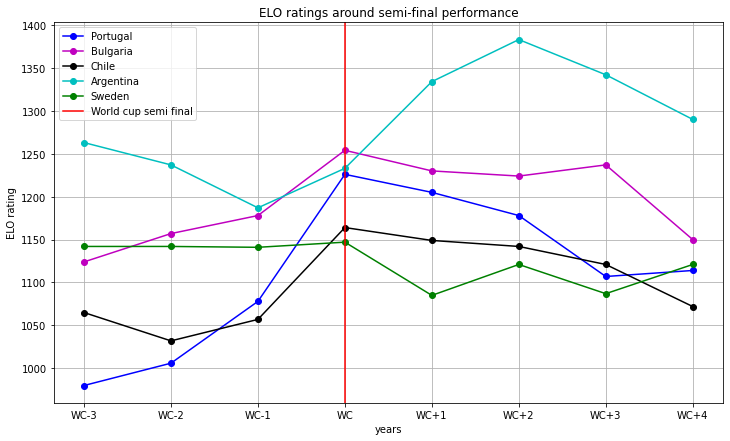

In [145]:
fig = plt.figure(figsize=(12,7))
ax = plt.axes()
x_axis = ['WC-3','WC-2','WC-1','WC','WC+1','WC+2','WC+3','WC+4']
plt.title("ELO ratings around semi-final performance")
plt.xlabel("years")
plt.ylabel("ELO rating")
#plt.xticks(x_axis)
show_elo_ratings("Portugal",1966,x_axis,'b',label="Portugal")
show_elo_ratings("Bulgaria",1994,x_axis,'m',label="Bulgaria")
show_elo_ratings("Chile",1962,x_axis,'k',label="Chile")
show_elo_ratings("Argentina",1990,x_axis,'c',label="Argentina")
show_elo_ratings("Sweden",1950,x_axis,'g',label="Sweden")

plt.grid()
plt.axvline(x='WC', label='World cup semi final', c='red')
plt.legend()

# Economic Impact of World Cup Performance

## GDP Growth Rate

In [148]:
gdp_growth_rate = pd.read_csv('../data/gdp_growth_rate.csv')

In [142]:
def show_gdp_growth_rate(team,year,x_axis,color,label):
    growth_rate = gdp_growth_rate[gdp_growth_rate['Country Name']==team].loc[:,str(year-2):str(year+2)]
    plt.plot(x_axis, growth_rate.values[0],marker='o',c=color,label= label) 
    return

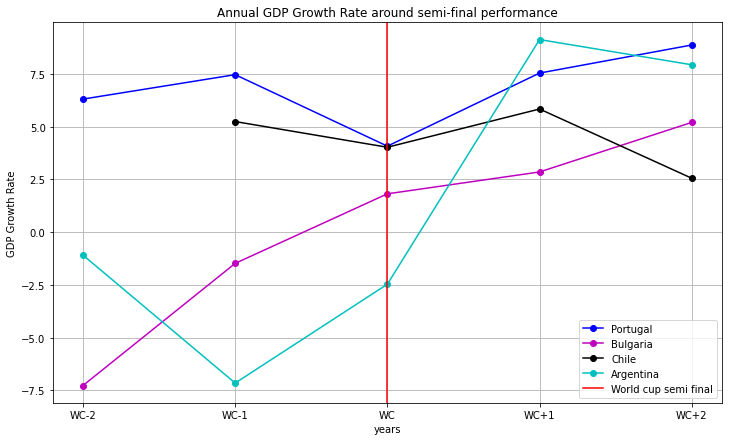

In [144]:
fig = plt.figure(figsize=(12,7))
ax = plt.axes()
x_axis = ['WC-2','WC-1','WC','WC+1','WC+2']
plt.title("Annual GDP Growth Rate around semi-final performance")
plt.xlabel("years")
plt.ylabel("GDP Growth Rate")
show_gdp_growth_rate("Portugal",1966,x_axis,'b',label="Portugal")
show_gdp_growth_rate("Bulgaria",1994,x_axis,'m',label="Bulgaria")
show_gdp_growth_rate("Chile",1962,x_axis,'k',label="Chile")
show_gdp_growth_rate("Argentina",1990,x_axis,'c',label="Argentina")
plt.grid()
plt.axvline(x='WC', label='World cup semi final', c='red')
plt.legend()

## GDP per Hour

In [162]:
gdp_per_hour = pd.read_csv('../data/gdp_per_hour.csv')
gdp_per_hour.head()

,Entity,Code,Year,Productivity: output per hour worked
0,Argentina,ARG,1950,3.727674
1,Argentina,ARG,1951,3.752668
2,Argentina,ARG,1952,3.365233
3,Argentina,ARG,1953,3.522695
4,Argentina,ARG,1954,3.623416


In [ ]:
gdp_per_hour[(gdp_per_hour['Entity']=="Portugal")&(gdp_per_hour['Year'].isin([*range(1964,1970)]))]

In [156]:
def show_gdp_per_hour(team,year,x_axis,color,label):
    productivity= gdp_per_hour[(gdp_per_hour['Entity']==team)&(gdp_per_hour['Year'].isin([*range(year-2,year+3)]))]
    plt.plot(x_axis, productivity['Productivity: output per hour worked'].values.tolist(),marker='o',c=color,label= label) 
    return

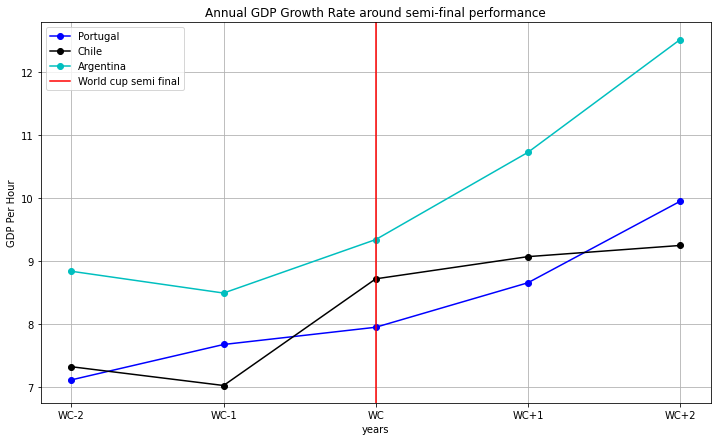

In [160]:
fig = plt.figure(figsize=(12,7))
ax = plt.axes()
x_axis = ['WC-2','WC-1','WC','WC+1','WC+2']
plt.title("Annual GDP Growth Rate around semi-final performance")
plt.xlabel("years")
plt.ylabel("GDP Per Hour")
show_gdp_per_hour("Portugal",1966,x_axis,'b',label="Portugal")
#show_gdp_per_hour("Bulgaria",1994,x_axis,'m',label="Bulgaria")
show_gdp_per_hour("Chile",1962,x_axis,'k',label="Chile")
show_gdp_per_hour("Argentina",1990,x_axis,'c',label="Argentina")
plt.grid()
plt.axvline(x='WC', label='World cup semi final', c='red')
plt.legend()

## Number of Tourists

In [ ]:
number_tourists = pd.read_csv('../data/number_tourists.csv')

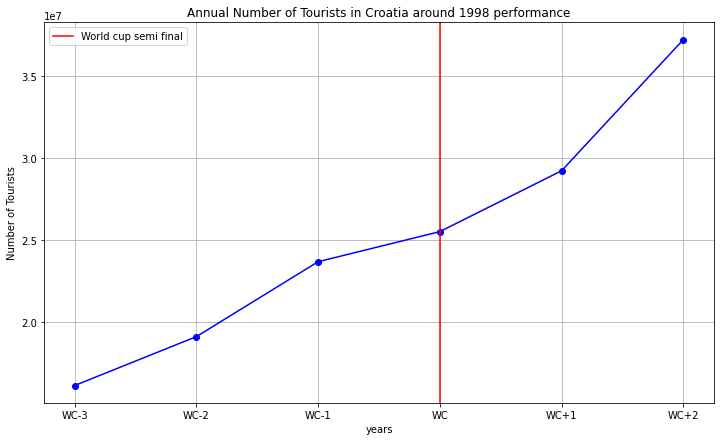

In [161]:
fig = plt.figure(figsize=(12,7))
ax = plt.axes()
x_axis = ['WC-3','WC-2','WC-1','WC','WC+1','WC+2']
plt.title("Annual Number of Tourists in Croatia around 1998 performance")
plt.xlabel("years")
plt.ylabel("Number of Tourists")
n_tourists = number_tourists[number_tourists['Country Name']== 'Croatia'].loc[:,str(1995):str(2000)]
n_tourists = n_tourists.values[0]
plt.plot(x_axis,n_tourists,marker='o',c='b')
plt.grid()
plt.axvline(x='WC', label='World cup semi final', c='red')
plt.legend()